In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapefile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import Point
import shapely
from shapely.geometry import *
from geopandas.geoseries import *
from scipy.spatial import distance

## 跑30K Data

In [31]:
_80k_real_data = pd.read_csv('tgos_80k.csv',index_col=0)
_80k_real_data.columns

Index(['index', '鄉鎮市區', '交易標的', '土地區段位置/建物區段門牌', '土地移轉總面積(平方公尺)', '都市土地使用分區',
       '非都市土地使用分區', '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次', '總樓層數', '建物型態',
       '主要用途', '主要建材', '建築完成年月', '建物移轉總面積(平方公尺)', '建物現況格局-房', '建物現況格局-廳',
       '建物現況格局-衛', '建物現況格局-隔間', '有無管理組織', '總價(元)', '單價(元/平方公尺)', '車位類別',
       '車位移轉總面積(平方公尺)', '車位總價(元)', '備註', '編號', '登記日期', 'Address_x', 'id',
       'Address_y', 'Response_Address', 'Response_X', 'Response_Y',
       'csv_file_name'],
      dtype='object')

In [32]:
_30k_real_data = _80k_real_data.iloc[0:30000,:]

In [89]:
_30k_real_data.shape

(30000, 37)

In [436]:
_5000_up_data = _30k_real_data[_30k_real_data['總價(元)']>=50000000]
_5000_up_data.to_csv('5千萬以上.csv')
_5000_up_data.shape

(425, 37)

In [5]:
Dali_btype = _80k_real_data.建物型態
Dali_btype = Dali_btype.reset_index(drop=True)
Dali_btype = pd.get_dummies(Dali_btype)
Dali_btype.columns

Index(['住宅大樓(11層含以上有電梯)', '倉庫', '公寓(5樓含以下無電梯)', '其他', '套房(1房1廳1衛)', '工廠',
       '店面(店鋪)', '廠辦', '華廈(10層含以下有電梯)', '辦公商業大樓', '農舍', '透天厝'],
      dtype='object')

In [6]:
Dali_age = pd.DataFrame((_80k_real_data.交易年月日-_80k_real_data.建築完成年月)/10000)
Dali_age.columns = ['Dali_age']
Dali_age=Dali_age.fillna('0')
Dali_age.shape
Dali_age=Dali_age.reset_index(drop=True)

In [11]:
Dali_area=pd.DataFrame(_80k_real_data['建物移轉總面積(平方公尺)'])
Dali_area=Dali_area.reset_index(drop=True)

In [12]:
POI_feature = pd.read_csv('POI_11_all.csv',index_col=0)
POI_feature.shape

(78685, 66)

In [13]:
yoga_30000_feature = pd.read_csv('30000_feature.csv')
yoga_30000_feature = yoga_30000_feature.drop(['住宅大樓', '公寓', '套房', '華廈',
       '透天厝', 'others', '商用', 'may_be_zero'],axis=1)
yoga_30000_feature = yoga_30000_feature.drop(['total_layers','BM_B','BM_R'],axis=1)

In [14]:
area_30000_feature = pd.read_csv('area.csv',index_col=0)
area_30000_feature.shape

(30000, 9)

In [15]:
#total_features = pd.concat([Dali_area.iloc[0:30000,:],Dali_btype.iloc[0:30000,:],yoga_30000_feature,Dali_age.iloc[0:30000,:],POI_feature.iloc[0:30000,:],area_30000_feature],axis=1)
total_features = pd.concat([Dali_area.iloc[0:30000,:],yoga_30000_feature,POI_feature.iloc[0:30000,:],area_30000_feature],axis=1)
total_features.columns

Index(['建物移轉總面積(平方公尺)', 'Rezone_5', 'Rezone_7', '中區', '北區', '北屯區', '南區', '南屯區',
       '后里區', '和平區',
       ...
       'POI_transport_cnt_2000', 'Indus_Res_100', 'Indus_Res_1000',
       'Indus_Res_1500', 'Indus_Res_200', 'Indus_Res_2000', 'Indus_Res_500',
       'Commercial_Res_100', 'Commercial_Res_1500', 'Commercial_Res_2000'],
      dtype='object', length=108)

# 讀取Yoga排掉親戚資料

In [32]:
total_features = pd.read_csv('without_relation.csv')
total_features.shape

(28834, 130)

# 讀取最後Feature資料 [最後R2以這裡為主]

In [35]:
total_features = pd.read_csv('final_plus_egg.csv')
total_features.shape

(26528, 130)

In [5]:
#total_features = pd.read_csv('27130.csv')

In [6]:
#total_features = _30k_real_data

In [7]:
total_features.columns.values

array(['單價(元/平方公尺)', '建物移轉總面積(平方公尺)', '住宅大樓(11層含以上有電梯)', '公寓(5樓含以下無電梯)',
       '套房(1房1廳1衛)', '華廈(10層含以下有電梯)', '透天厝', 'Rezone_5', 'Rezone_7', '中區',
       '北區', '北屯區', '南區', '南屯區', '后里區', '和平區', '外埔區', '大安區', '大甲區', '大肚區',
       '大里區', '大雅區', '太平區', '新社區', '東勢區', '東區', '梧棲區', '沙鹿區', '清水區', '潭子區',
       '烏日區', '石岡區', '神岡區', '西區', '西屯區', '豐原區', '霧峰區', '龍井區', 'admin_area',
       'BM_B', 'BM_R', 'Dali_age', 'POI_conv_cnt_100', 'POI_conv_cnt_200',
       'POI_conv_cnt_500', 'POI_conv_cnt_1000', 'POI_conv_cnt_1500',
       'POI_conv_cnt_2000', 'POI_hotel_cnt_100', 'POI_hotel_cnt_200',
       'POI_hotel_cnt_500', 'POI_hotel_cnt_1000', 'POI_hotel_cnt_1500',
       'POI_hotel_cnt_2000', 'POI_library_cnt_100', 'POI_library_cnt_200',
       'POI_library_cnt_500', 'POI_library_cnt_1000',
       'POI_library_cnt_1500', 'POI_library_cnt_2000',
       'POI_market_cnt_100', 'POI_market_cnt_200', 'POI_market_cnt_500',
       'POI_market_cnt_1000', 'POI_market_cnt_1500', 'POI_market_cnt_2000',
      

In [37]:
total_features = total_features.drop(['總價_exeme_0.005',
       '單價_exeme_0.005', '面積_exeme_0.005', 'Extreme_case_0.005','POI_museum_cnt_100', 'POI_museum_cnt_200', 'POI_museum_cnt_500',
       'POI_museum_cnt_1000', 'POI_museum_cnt_1500', 'POI_museum_cnt_2000'],axis=1)

In [71]:
total_features = total_features.drop(['住宅大樓(11層含以上有電梯)', '公寓(5樓含以下無電梯)',
       '套房(1房1廳1衛)', '華廈(10層含以下有電梯)', '透天厝','BM_B',
       'BM_R','Dali_age','total_layers'],axis=1)

In [72]:
total_features = total_features.drop(['中區',
       '北區', '北屯區', '南區', '南屯區', '后里區', '和平區', '外埔區', '大安區', '大甲區', '大肚區',
       '大里區', '大雅區', '太平區', '新社區', '東勢區', '東區', '梧棲區', '沙鹿區', '清水區', '潭子區',
       '烏日區', '石岡區', '神岡區', '西區', '西屯區', '豐原區', '霧峰區', '龍井區', 'admin_area'],axis=1)

In [73]:
total_features = total_features.drop(['egg_out', 'egg_in',
       'egg_mid','Rezone_5', 'Rezone_7','Indus_Res_1500', 'Indus_Res_200', 'Indus_Res_2000',
       'Indus_Res_500', 'Commercial_Res_100', 'Commercial_Res_1500',
       'Commercial_Res_2000', 'Commercial_Res_1000',
       'Commercial_Res_200', 'Commercial_Res_500','Indus_Res_100', 'Indus_Res_1000',
       'bt_trans'],axis=1)

# 排除非住宅建物型態

In [98]:
total_features = total_features[total_features['農舍']==0]
total_features = total_features[total_features['倉庫']==0]
total_features = total_features[total_features['其他']==0]
total_features = total_features[total_features['工廠']==0]
total_features = total_features[total_features['店面(店鋪)']==0]
total_features = total_features[total_features['廠辦']==0]
total_features = total_features[total_features['辦公商業大樓']==0]

In [99]:
total_features = total_features.drop(['農舍','倉庫','其他','工廠','店面(店鋪)','廠辦','辦公商業大樓'],axis=1)

#total_features = total_features[total_features['總價(元)']<100000000]

# 屋齡小於0補成0

In [100]:
_smaller_than0_=list(total_features[total_features['Dali_age']<0].index)
total_features['Dali_age'].loc[_smaller_than0_]=0
len(_smaller_than0_)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


4828

# 只考慮地域因素

In [520]:
total_features = total_features.drop(['Dali_age','total_layers','住宅大樓(11層含以上有電梯)', '公寓(5樓含以下無電梯)',
       '套房(1房1廳1衛)', '華廈(10層含以下有電梯)', '透天厝','BM_B','BM_R'],axis=1)

# 建立總價Label

In [38]:
label = total_features['總價(元)']
label = label.fillna(0)
#label = label.as_matrix()
median = np.median(label[label > 0])
label[label == 0] = median
label=np.log10(label)
label = pd.DataFrame(label)
#label = label.iloc[0:30000,:]
#label=label.reset_index(drop=True)
#label.shape

In [101]:
label = total_features['總價(元)']
np.any(np.isnan(label))

False

# 建立單價Label

In [42]:
label = total_features['單價(元/平方公尺)']
label=label.fillna(0)
#label = label.as_matrix()
median = np.median(label[label > 0])
label[label == 0] = median
label=np.log10(label)
label = pd.DataFrame(label)
#label = label.iloc[0:30000,:]
#label=label.reset_index(drop=True)
label.shape

56086.0

In [102]:
label = total_features['單價(元/平方公尺)']
np.any(np.isnan(label))

False

# 前後1%排除作業

In [341]:
index=list(label.sort_values(by=['總價(元)']).index)
total_features['總價0.1_L']=0
total_features['總價0.1_H']=0
total_features['總價0.1_L'].loc[list(total_features.loc[index].iloc[0:271,:].index)]=1
total_features['總價0.1_H'].loc[list(total_features.loc[index].iloc[26859:27130,:].index)]=1
#list(total_features.loc[index].iloc[0:26588,:].index)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [310]:
index=list(label.sort_values(by=['單價(元/平方公尺)']).index)
total_features['單價(元/平方公尺)0.1_L']=0
total_features['單價(元/平方公尺)0.1_H']=0
total_features['單價(元/平方公尺)0.1_L'].loc[list(total_features.loc[index].iloc[0:271,:].index)]=1
total_features['單價(元/平方公尺)0.1_H'].loc[list(total_features.loc[index].iloc[26859:27130,:].index)]=1

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [92]:
total_features.shape

(27130, 123)

# Rita 排除前後0.5%作業

In [82]:
# 排除極端值

q = 0.005

tp_q = total_features['總價(元)'].quantile(q)
tp_1_q = total_features['總價(元)'].quantile(1 - q)

ep_q = total_features['單價(元/平方公尺)'].quantile(q)
ep_1_q = total_features['單價(元/平方公尺)'].quantile(1 - q)

area_q = total_features['建物移轉總面積(平方公尺)'].quantile(q)
area_1_q = total_features['建物移轉總面積(平方公尺)'].quantile(1 - q)


print('總價 0.5% - {} / 0.995% - {}'.format(tp_q, tp_1_q))
print('單價 0.5% - {} / 0.995% - {}'.format(ep_q, ep_1_q))
print('面積 0.5% - {} / 0.995% - {}'.format(area_q, area_1_q))



總價 0.5% - 800000.0 / 0.995% - 71987100.0
單價 0.5% - 17321.635000000002 / 0.995% - 191624.0299999999
面積 0.5% - 21.8529 / 0.995% - 586.7916999999998


In [83]:
def quantile_tp_q(x):
    if x <= tp_q:
        return 1
    elif x >= tp_1_q:
        return 1
    else:
        return 0

def quantile_ep_q(x):
    if x <= ep_q:
        return 1
    elif x >= ep_1_q:
        return 1
    else:
        return 0
    
def quantile_area_q(x):
    if x <= area_q:
        return 1
    elif x >= area_1_q:
        return 1
    else:
        return 0

In [84]:
total_features['總價_exeme_0.005'] = total_features['總價(元)'].map(quantile_tp_q)
total_features['單價_exeme_0.005'] = total_features['單價(元/平方公尺)'].map(quantile_ep_q)
total_features['面積_exeme_0.005'] = total_features['建物移轉總面積(平方公尺)'].map(quantile_area_q)

total_features['Extreme_case_0.005'] = (total_features['總價_exeme_0.005'] == 1) | (total_features['單價_exeme_0.005'] == 1) | (total_features['面積_exeme_0.005'] == 1)

In [85]:
total_features['Extreme_case_0.005'].value_counts()

False    26528
True       602
Name: Extreme_case_0.005, dtype: int64

In [79]:
total_features = total_features[total_features['Extreme_case_0.005'] == 0]

In [531]:
#2total_features.to_csv('final_data_26528.csv')

In [42]:
total_features = total_features.drop('總價(元)',axis=1)
total_features = total_features.drop('單價(元/平方公尺)',axis=1)

In [15]:
total_features = total_features.drop('建物移轉總面積(平方公尺)',axis=1)

In [39]:
label=label.reset_index(drop=True)
total_features=total_features.reset_index(drop=True)

In [12]:
label.columns.values

array(['總價(元)'], dtype=object)

# 跑XGBoost 建立Model

In [43]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
% pylab inline
X_train, X_test, Y_train, Y_test = train_test_split(total_features.as_matrix(), label.as_matrix(), test_size=0.3,random_state=77)
eval_set =  [(X_test, Y_test)]

print('start modelling!')
model = XGBRegressor(n_estimators=1000,max_depth=4,nthread=4)
model.fit(X_train, Y_train, early_stopping_rounds=50, eval_metric="rmse", eval_set=eval_set,
         verbose=True)

Populating the interactive namespace from numpy and matplotlib
start modelling!
[0]	validation_0-rmse:5.76022
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.18478
[2]	validation_0-rmse:4.66706
[3]	validation_0-rmse:4.20103
[4]	validation_0-rmse:3.78169
[5]	validation_0-rmse:3.40414
[6]	validation_0-rmse:3.06451
[7]	validation_0-rmse:2.75881
[8]	validation_0-rmse:2.48375
[9]	validation_0-rmse:2.2361
[10]	validation_0-rmse:2.01333
[11]	validation_0-rmse:1.81289
[12]	validation_0-rmse:1.63243
[13]	validation_0-rmse:1.47003
[14]	validation_0-rmse:1.32404
[15]	validation_0-rmse:1.19256
[16]	validation_0-rmse:1.07431
[17]	validation_0-rmse:0.967906
[18]	validation_0-rmse:0.872291
[19]	validation_0-rmse:0.786279
[20]	validation_0-rmse:0.708912
[21]	validation_0-rmse:0.639443
[22]	validation_0-rmse:0.577035
[23]	validation_0-rmse:0.52089
[24]	validation_0-rmse:0.470634
[25]	validation_0-rmse:0.42542
[26]	validation_0-rmse:0.385026
[27]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# 計算R2 Score

In [44]:
from sklearn.metrics import r2_score
model.score(X_test,Y_test)
Y_pred = model.predict(X_test)
r2_score(Y_test,Y_pred)

0.94253018226115792

# Check Feature Imporatnce

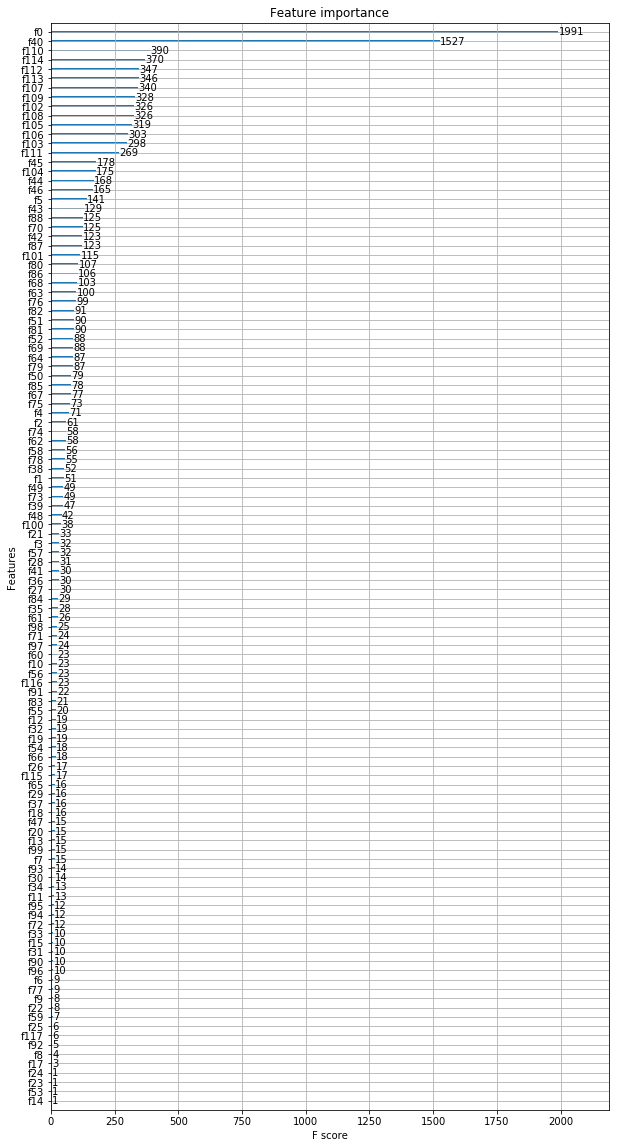

In [46]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize = (10, 20))
plot_importance(model,ax=ax,importance_type='weight')
plt.show()

# 儲存特徵Weight值

In [47]:
importances = pd.DataFrame({'feature':total_features.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print(importances)
importances.to_csv('XGB_imporance_.csv')

                         importance
feature                            
建物移轉總面積(平方公尺)                 0.163
Dali_age                      0.125
Commercial_Res_1000           0.032
bt_trans                      0.030
Commercial_Res_100            0.028
total_layers                  0.028
Commercial_Res_500            0.028
Commercial_Res_2000           0.027
Commercial_Res_1500           0.027
Indus_Res_1000                0.027
Indus_Res_2000                0.026
Indus_Res_500                 0.025
Indus_Res_1500                0.024
Commercial_Res_200            0.022
POI_conv_cnt_1500             0.015
POI_conv_cnt_2000             0.014
POI_conv_cnt_1000             0.014
Indus_Res_200                 0.014
透天厝                           0.012
POI_conv_cnt_500              0.011
POI_school_cnt_2000           0.010
POI_school_cnt_1500           0.010
POI_park_cnt_2000             0.010
POI_conv_cnt_200              0.010
POI_school_cnt_1000           0.009
POI_rest_cnt_1000           

# 特徵值視覺化 Method1

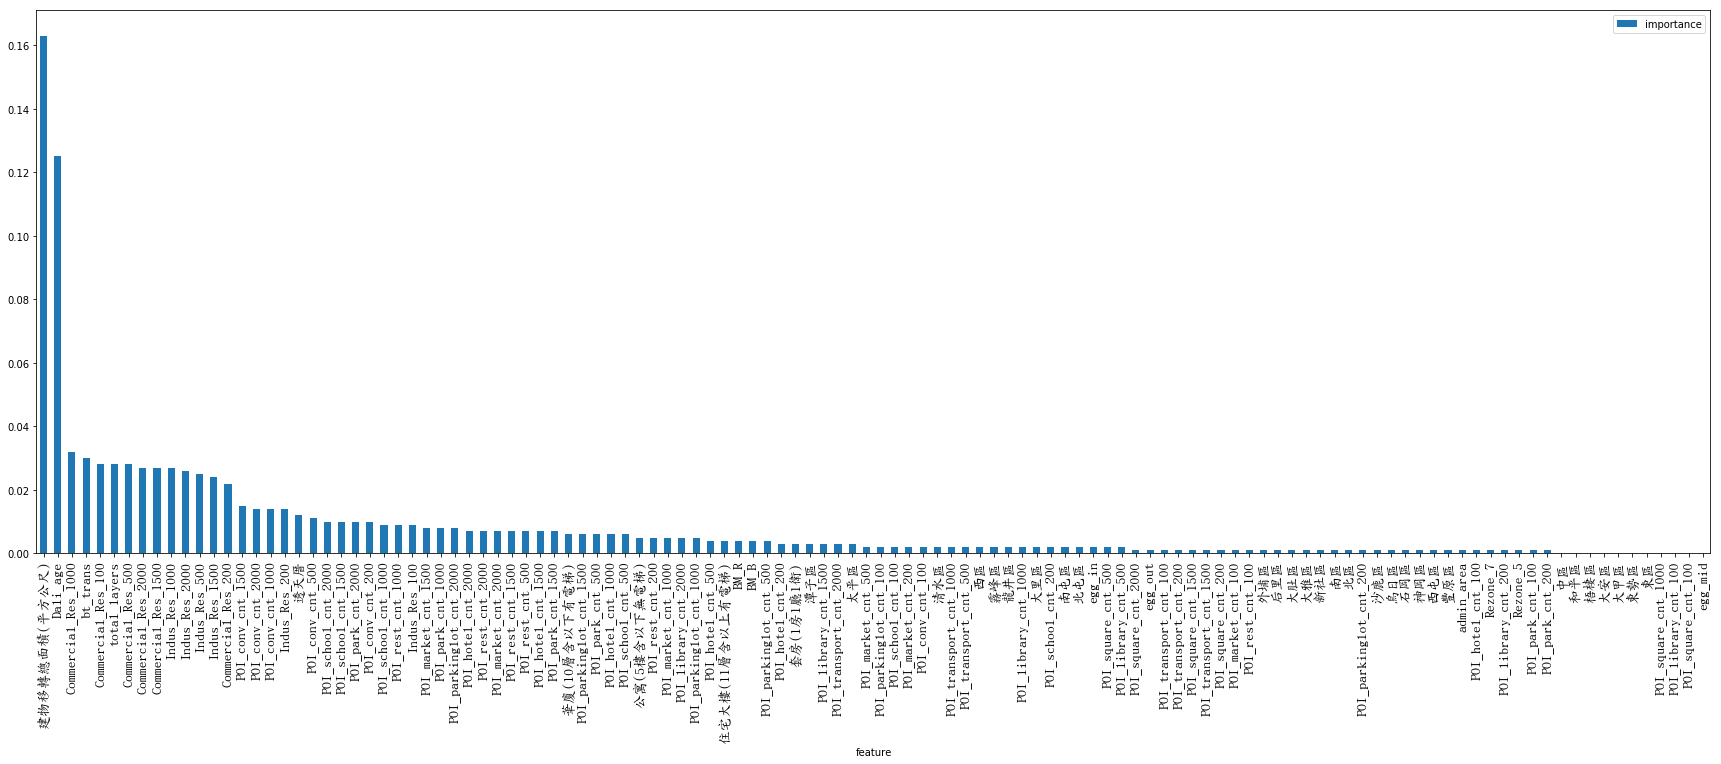

In [27]:
from pandas import DataFrame 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname=r"bkai00mp.ttf", size=14) 

#color_dict = {'建物移轉總面積(平方公尺)': '#FF0000'}

fig, ax = plt.subplots(figsize = (30, 10))

for label in ax.get_xticklabels() : 
    label.set_fontproperties(font) 
importances.plot.bar(ax=ax)


# Testing Data預測與實際值排序

In [48]:
s_Y_test=np.sort(Y_test, axis=0)
s_Y_pred=np.sort(Y_pred, axis=0)
s_Y_test = np.squeeze(s_Y_test)

# 畫出實際與預測排序後 總價 或 單價 比對 視覺曲線圖

Text(0,0.5,'Total Price')

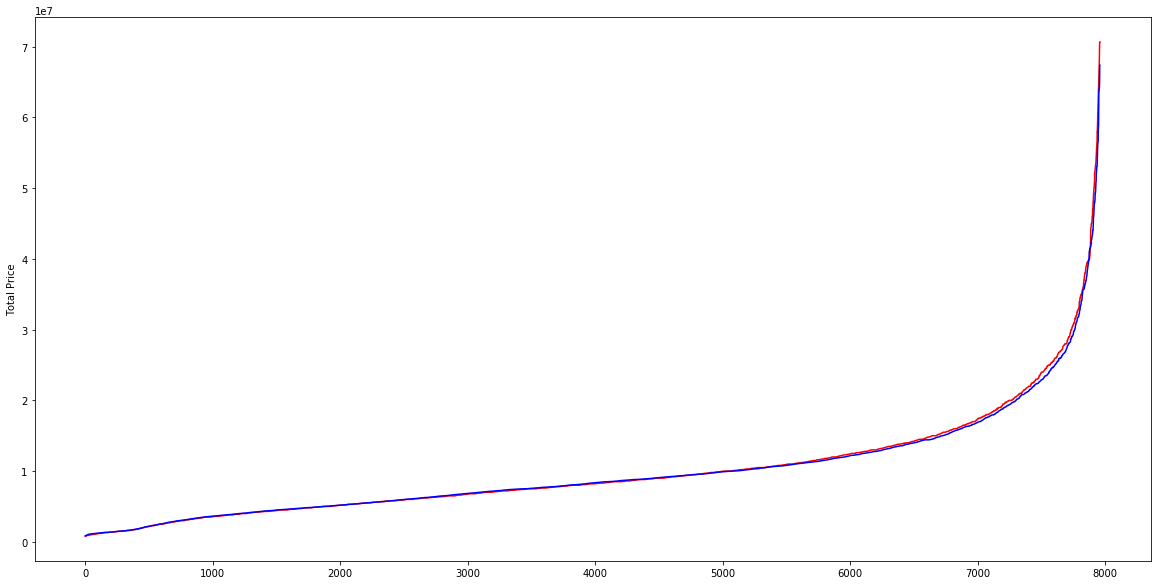

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
#plt.plot(10**s_Y_test-10**s_Y_pred,color='red')
plt.plot(10**s_Y_test,color='red')
plt.plot(10**s_Y_pred,color='blue')
plt.ylabel('Total Price')
#plt.show()
#plt.imsave('XGB_X1[0.94379830462621239]總價.png')
#plt.savefig('XGB_X3[0.5092700619197974]單價.png')

# 儲存Machine Learning XGBoost Model

In [30]:
import pickle
pickle.dump(model, open("NCKU_House_Predict_XGB_X3_單價.model", "wb"))

In [53]:
with open("NCKU_House_Predict_XGB_X1_總價.model", 'rb') as file:  
    pickle_model = pickle.load(file)

# 另一種XGBoost跑法

In [51]:
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(total_features.as_matrix(), label.as_matrix(), test_size=0.3, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train,feature_names=total_features.columns.values)
d_valid = xgb.DMatrix(x_valid, label=y_valid,feature_names=total_features.columns.values)
#d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4
params['n_estimator'] = 1000
params['nthread'] = 4
#params['learning_rate']=0.01

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=500, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:6.27754	valid-rmse:6.27557	train-r2:-397.899	valid-r2:-393.37
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 500 rounds.
[10]	train-rmse:5.13026	valid-rmse:5.12877	train-r2:-265.418	valid-r2:-262.405
[20]	train-rmse:4.19292	valid-rmse:4.19193	train-r2:-176.958	valid-r2:-174.964
[30]	train-rmse:3.42711	valid-rmse:3.4264	train-r2:-117.889	valid-r2:-116.564
[40]	train-rmse:2.80146	valid-rmse:2.80093	train-r2:-78.4425	valid-r2:-77.56
[50]	train-rmse:2.29034	valid-rmse:2.28994	train-r2:-52.0988	valid-r2:-51.5105
[60]	train-rmse:1.87283	valid-rmse:1.87263	train-r2:-34.5042	valid-r2:-34.1158
[70]	train-rmse:1.53175	valid-rmse:1.53175	train-r2:-22.7497	valid-r2:-22.4949
[80]	train-rmse:1.25313	valid-rmse:1.2533	train-r2:-14.8955	valid-r2:-14.7293
[90]	train-rmse:1.02563	valid-rmse:1.02593	train-r2:-9.64792	valid-r2:-9.53984
[100]	train-rmse:0.839965	valid-rmse:0.840403	train-r2:-6.14177	valid-r2:-

# 以下是實驗Code不用看 謝謝各位助教的辛勞 謝謝!!!

In [179]:
df = total_features #30000 筆 feature
#df1 = pd.read_csv('at071-group01/tgos_80k.csv') #實價登陸的資料
df1 = _30k_real_data

#df2['備註'] = df2.備註.fillna('無備註')

#df2 = df2[~df2.備註.str.contains('間之')]
df1 = df1.reset_index(drop=True)
df2 = pd.concat([df1,df],axis = 1)
df2.shape

(30000, 161)

In [180]:
df2['備註'] = df2.備註.fillna('無備註')

df2 = df2[~df2.備註.str.contains('間之')]

In [181]:
df2.shape

(28834, 161)

In [182]:
non_car_list=pd.DataFrame(df2['交易筆棟數'].str.split('車位').str.get(1))
#non_car = _80k_real_data.loc[non_car_list]
non_car_list=non_car_list[non_car_list.交易筆棟數.astype(int)!=0]
df22=df2.loc[non_car_list.index]
df22.shape

(15434, 161)

In [183]:
df22.columns.values

array(['index', '鄉鎮市區', '交易標的', '土地區段位置/建物區段門牌', '土地移轉總面積(平方公尺)',
       '都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次',
       '總樓層數', '建物型態', '主要用途', '主要建材', '建築完成年月', '建物移轉總面積(平方公尺)',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間', '有無管理組織', '總價(元)',
       '單價(元/平方公尺)', '車位類別', '車位移轉總面積(平方公尺)', '車位總價(元)', '備註', '編號',
       '登記日期', 'Address_x', 'id', 'Address_y', 'Response_Address',
       'Response_X', 'Response_Y', 'csv_file_name', '建物移轉總面積(平方公尺)',
       '住宅大樓(11層含以上有電梯)', '倉庫', '公寓(5樓含以下無電梯)', '其他', '套房(1房1廳1衛)', '工廠',
       '店面(店鋪)', '廠辦', '華廈(10層含以下有電梯)', '辦公商業大樓', '農舍', '透天厝', 'Rezone_5',
       'Rezone_7', '中區', '北區', '北屯區', '南區', '南屯區', '后里區', '和平區', '外埔區',
       '大安區', '大甲區', '大肚區', '大里區', '大雅區', '太平區', '新社區', '東勢區', '東區', '梧棲區',
       '沙鹿區', '清水區', '潭子區', '烏日區', '石岡區', '神岡區', '西區', '西屯區', '豐原區', '霧峰區',
       '龍井區', 'admin_area', 'BM_B', 'BM_R', 'Dali_age', 'POI_conv_cnt_100',
       'POI_conv_cnt_200', 'POI_conv_cnt_500', 'POI_conv_cnt_1000',


In [185]:
df222 = df22.drop(['index', '鄉鎮市區', '交易標的', '土地區段位置/建物區段門牌', '土地移轉總面積(平方公尺)',
       '都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次',
       '總樓層數', '建物型態', '主要用途', '主要建材', '建築完成年月', '建物移轉總面積(平方公尺)',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間', '有無管理組織', '總價(元)',
       '單價(元/平方公尺)', '車位類別', '車位移轉總面積(平方公尺)', '車位總價(元)', '備註', '編號',
       '登記日期', 'Address_x', 'id', 'Address_y', 'Response_Address',
       'Response_X', 'Response_Y', 'csv_file_name'],axis=1)


In [184]:
label2 = df22.iloc[:,160:161]
label2=label2.fillna(0)
label2 = label2.as_matrix()
median = np.median(label2[label2 > 0])
label2[label2 == 0] = median
label2=np.log10(label2)
label2 = pd.DataFrame(label2)
label2=label2.reset_index(drop=True)
label2.shape

(15434, 1)

In [186]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
% pylab inline
X_train, X_test, Y_train, Y_test = train_test_split(df222.as_matrix(), label2.as_matrix(), test_size=0.3)
eval_set =  [(X_test, Y_test)]

print('start modelling!')
model = XGBRegressor(n_estimators=1000,max_depth=4)
model.fit(X_train, Y_train, early_stopping_rounds=50, eval_metric="rmse", eval_set=eval_set,
         verbose=True)

Populating the interactive namespace from numpy and matplotlib
start modelling!
[0]	validation_0-rmse:5.83475
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.25231
[2]	validation_0-rmse:4.72812


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[3]	validation_0-rmse:4.25664
[4]	validation_0-rmse:3.83241
[5]	validation_0-rmse:3.45065
[6]	validation_0-rmse:3.10723
[7]	validation_0-rmse:2.79814
[8]	validation_0-rmse:2.52009
[9]	validation_0-rmse:2.26996
[10]	validation_0-rmse:2.04476
[11]	validation_0-rmse:1.8422
[12]	validation_0-rmse:1.66026
[13]	validation_0-rmse:1.49639
[14]	validation_0-rmse:1.34935
[15]	validation_0-rmse:1.21719
[16]	validation_0-rmse:1.09829
[17]	validation_0-rmse:0.991406
[18]	validation_0-rmse:0.895309
[19]	validation_0-rmse:0.809275
[20]	validation_0-rmse:0.732096
[21]	validation_0-rmse:0.662972
[22]	validation_0-rmse:0.601125
[23]	validation_0-rmse:0.545728
[24]	validation_0-rmse:0.496062
[25]	validation_0-rmse:0.451978
[26]	validation_0-rmse:0.412814
[27]	validation_0-rmse:0.377895
[28]	validation_0-rmse:0.346654
[29]	validation_0-rmse:0.319095
[30]	validation_0-rmse:0.29491
[31]	validation_0-rmse:0.273976
[32]	validation_0-rmse:0.255336
[33]	validation_0-rmse:0.239357
[34]	validation_0-rmse:0.225391

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)